# LSTM forecast model for a one-step univariate time series forecasting problem

### Import libraries

In [92]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

### Load and explore data

In [7]:
df = pdr.get_data_yahoo('AAPL', '20180102')
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,43.075001,42.314999,42.540001,43.064999,102223600.0,41.380238
2018-01-03,43.637501,42.990002,43.132500,43.057499,118071600.0,41.373032
2018-01-04,43.367500,43.020000,43.134998,43.257500,89738400.0,41.565216
2018-01-05,43.842499,43.262501,43.360001,43.750000,94640000.0,42.038452
2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,41.882305


In [8]:
df.isnull().sum() # check for missing values

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [9]:
len(df) # lenght of dataset

816

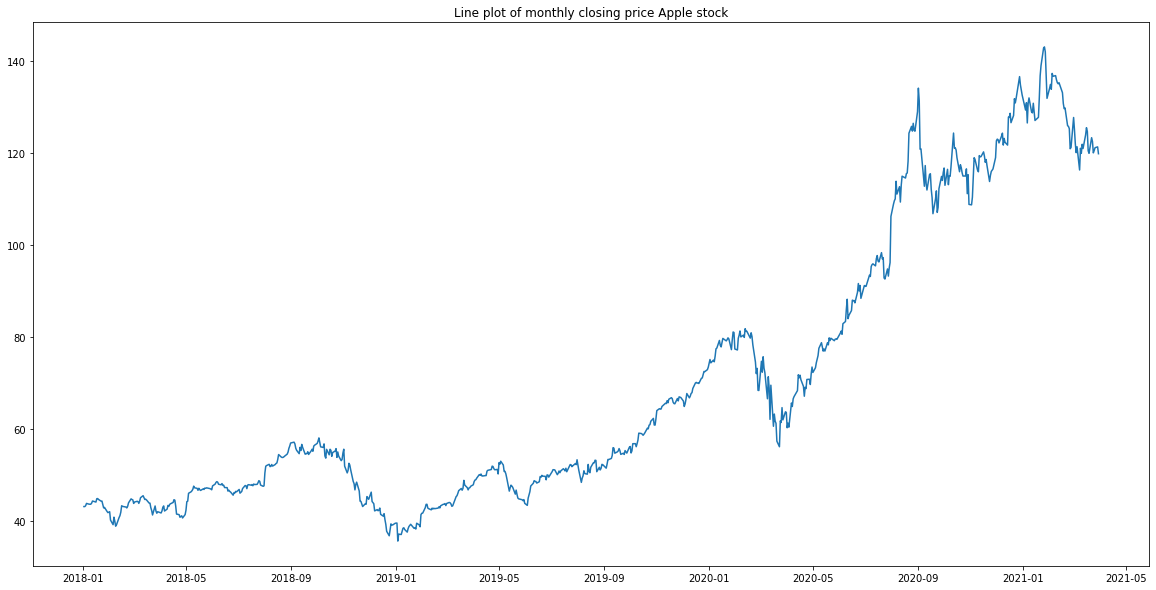

In [10]:
plt.plot(df.Close)
plt.title('Line plot of monthly closing price Apple stock')
plt.show()

### Base line performance : persistence model forecast

A good baseline forecast for a time series with a linear increasing trend is a persistence forecast. We can implement this by taking the last observation from the training data and history accumulated by walk-forward validation and using that to predict the current time step.

RMSE: 2.709


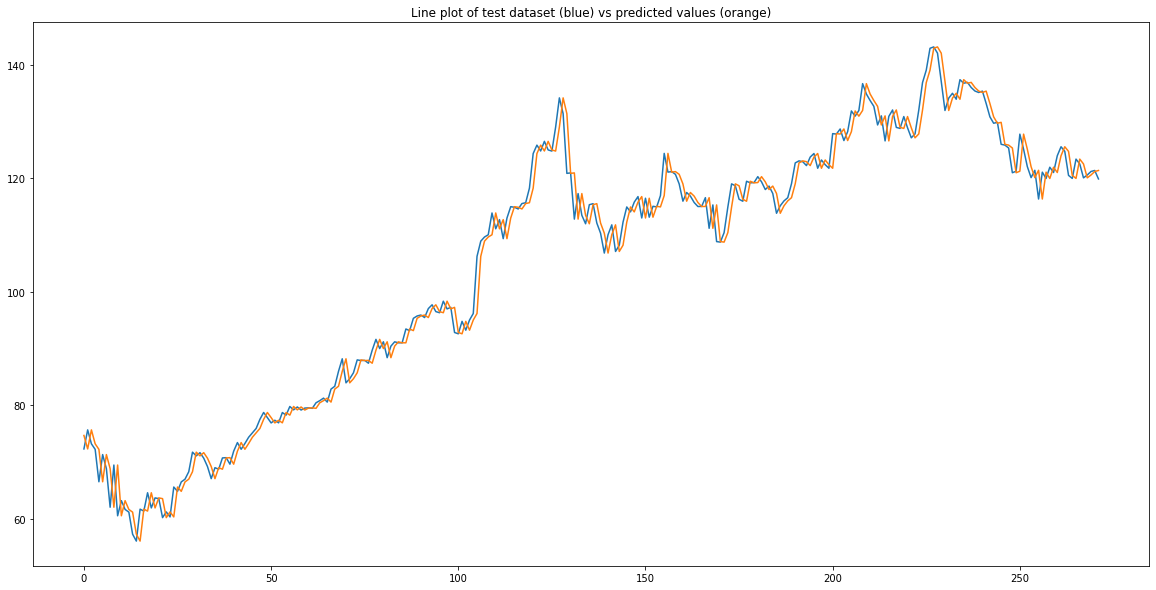

In [67]:
# split data into train and test
X = df.Close.values
train, test = X[0:-272], X[-272:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test)
plt.plot(predictions)
plt.title('Line plot of test dataset (blue) vs predicted values (orange)')
plt.show()

### LSTM Data Preparation

Time series forecasting can be framed as a supervised learning problem.

This re-framing of your time series data allows you access to the suite of standard linear and nonlinear machine learning algorithms on your problem.

In [81]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [82]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [83]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [84]:
# check for stationary
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.283358
p-value: 0.927829
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


 it looks like we would have to fail to reject the null hypothesis that the time series is non-stationary and does have time-dependent structure. Differencing is needed.

The Apple closing prices dataset is not stationary.

This means that there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.

In [103]:
raw_values = df.Close.values

In [104]:
# transform data to be sationary
diff_values = difference(raw_values, 1) #lag 1
diff_values.head()

0   -0.007500
1    0.200001
2    0.492500
3   -0.162498
4   -0.005001
dtype: float64

In [105]:
# check for stationary
result = adfuller(diff_values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.604362
p-value: 0.000001
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


Data is now stationairy

The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.

In [106]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
supervised_values

array([[ 0.        , -0.00749969],
       [-0.00749969,  0.20000076],
       [ 0.20000076,  0.49250031],
       ...,
       [ 0.5       ,  0.62000275],
       [ 0.62000275,  0.18000031],
       [ 0.18000031, -1.48999786]])

### Split data into train and test-sets

In [87]:
# split data into train and test-sets
X_train, X_test = supervised_values[0:-272], supervised_values[-272:]

### Transforming the data so that it has the scale -1 to 1.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

In [56]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [97]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

To make the experiment fair, the scaling coefficients (min and max) values must be calculated on the training dataset and applied to scale the test dataset and any forecasts. This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

In [88]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(X_train, X_test)

### LSTM Model Development

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

Samples: These are independent observations from the domain, typically rows of data.

Time steps: These are separate time steps of a given variable for a given observation.

Features: These are separate measures observed at the time of observation.

In [59]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [60]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [95]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4) # random values for nb_epoch and neurons
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-1.46220401e-01],
       [-1.00818753e-01],
       [-1.05063260e-01],
       [-1.70591608e-01],
       [-1.27050683e-01],
       [-1.12623423e-01],
       [-1.93049327e-01],
       [-6.19840026e-02],
       [-2.34570757e-01],
       [-4.66696471e-02],
       [-2.55537182e-01],
       [-3.96069884e-02],
       [-2.38045052e-01],
       [-5.99029511e-02],
       [-2.46350288e-01],
       [-8.62048566e-02],
       [-1.06271341e-01],
       [-1.64728940e-01],
       [-7.31606185e-02],
       [-1.03569716e-01],
       [ 2.23964453e-02],
       [ 2.94399559e-02],
       [-2.22728848e-02],
       [-1.56763792e-02],
       [-2.19927847e-01],
       [-1.34079054e-01],
       [-3.75459790e-02],
       [-1.31567687e-01],
       [-1.31865829e-01],
       [-1.86589181e-01],
       [-1.40021443e-01],
       [-1.44591436e-01],
       [-1.16510704e-01],
       [-1.36121422e-01],
       [-1.07938290e-01],
       [-1.33867890e-01],
       [-1.10451058e-01],
       [-1.32287353e-01],
       [-1.1

In [124]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + 1 - i]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Day=1, Predicted=74.866876, Expected=75.684998
Day=2, Predicted=72.511187, Expected=72.330002
Day=3, Predicted=76.240203, Expected=74.702499
Day=4, Predicted=73.478921, Expected=68.339996
Day=5, Predicted=72.261797, Expected=68.379997
Day=6, Predicted=66.350818, Expected=73.162498
Day=7, Predicted=70.752015, Expected=72.019997
Day=8, Predicted=68.546093, Expected=74.544998
Day=9, Predicted=61.867371, Expected=78.262497
Day=10, Predicted=69.999594, Expected=80.074997
Day=11, Predicted=60.025303, Expected=80.904999
Day=12, Predicted=62.689489, Expected=79.750000
Day=13, Predicted=61.604305, Expected=81.237503
Day=14, Predicted=61.456240, Expected=81.217499
Day=15, Predicted=57.415741, Expected=81.800003
Day=16, Predicted=56.436486, Expected=79.902496
Day=17, Predicted=61.451552, Expected=80.387497
Day=18, Predicted=61.622926, Expected=80.007500
Day=19, Predicted=64.698557, Expected=81.302498
Day=20, Predicted=61.831328, Expected=80.362503
Day=21, Predicted=63.654113, Expected=79.712502
D

Test RMSE: 2.713


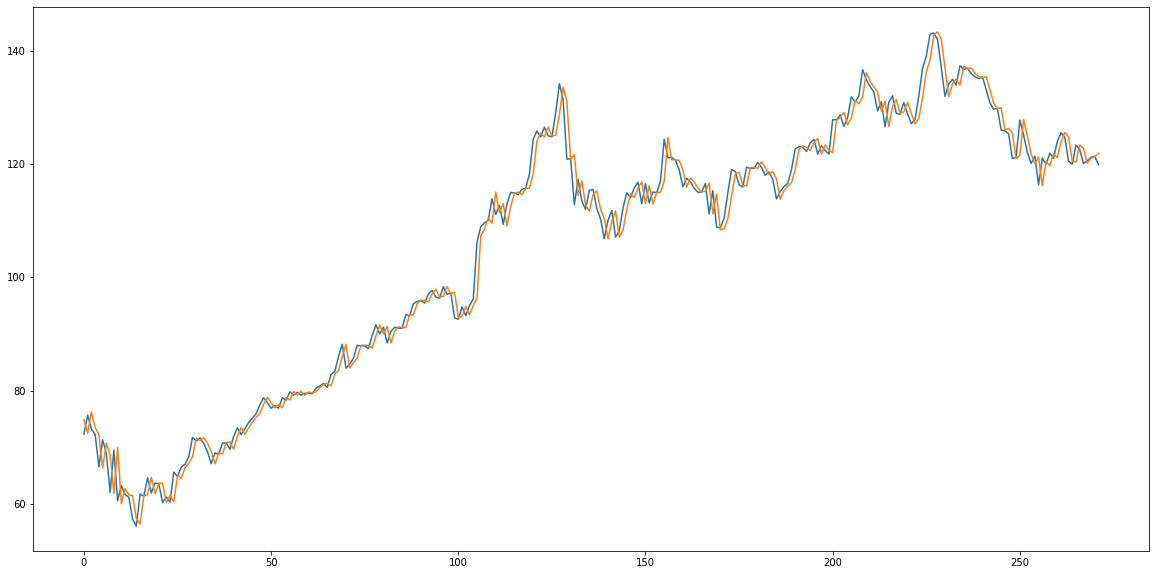

In [127]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-272:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-272:])
plt.plot(predictions)
plt.show()

### Develop a robust result

A difficulty with neural networks is that they give different results with different starting conditions.

One approach might be to fix the random number seed used by Keras to ensure the results are reproducible. Another approach would be to control for the random initial conditions using a different experimental setup.

We can repeat the experiment from the previous section multiple times, then take the average RMSE as an indication of how well the configuration would be expected to perform on unseen data on average.

In [128]:
# repeat experiment: needed to stop early as it takes too long time
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-272:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)
    
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.show()

1) Test RMSE: 8.657
2) Test RMSE: 4.092


KeyboardInterrupt: 